In [0]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def cosine_annealing_schedule(t,modval=50,max_lr=0.3):
  modval=int(modval)
  cos_inner = (np.pi * (t % modval))/ modval
  cos_out = np.cos(cos_inner) + 1
  return float(max_lr / 2 * cos_out)

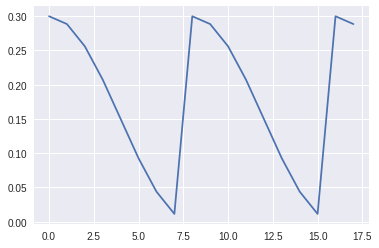

In [0]:
epochs,modval,max_lr=18,8,0.3
nr=list(range(epochs))
cosine_annealing_vals=[cosine_annealing_schedule(i,modval,max_lr) for i in nr]
plt.plot(nr,cosine_annealing_vals)

In [0]:
[cosine_annealing_vals[index-1] for index in [modval]]

[0.04393398282201788]

In [0]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 914 (delta 0), reused 0 (delta 0), pack-reused 913
Receiving objects: 100% (914/914), 125.52 MiB | 37.40 MiB/s, done.
Resolving deltas: 100% (525/525), done.


In [0]:
!cd Mask_RCNN && pip install  -r requirements.txt

    100% |████████████████████████████████| 204kB 22.6MB/s 


In [0]:
!cd Mask_RCNN&& python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/l

In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


In [0]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [0]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


InvalidArgumentError: ignored

In [0]:
!ls

In [0]:
!git clone https://github.com/pjreddie/darknet darknet_dir

Cloning into 'darknet_dir'...
remote: Enumerating objects: 5901, done.
remote: Total 5901 (delta 0), reused 0 (delta 0), pack-reused 5901
Receiving objects: 100% (5901/5901), 6.15 MiB | 8.66 MiB/s, done.
Resolving deltas: 100% (3938/3938), done.


In [0]:
#cd darknet
!mv -v darknet_dir/* ./
!make
!wget https://pjreddie.com/media/files/yolov3-tiny.weights

renamed 'darknet_dir/cfg' -> './cfg'
renamed 'darknet_dir/data' -> './data'
renamed 'darknet_dir/examples' -> './examples'
renamed 'darknet_dir/include' -> './include'
renamed 'darknet_dir/LICENSE' -> './LICENSE'
renamed 'darknet_dir/LICENSE.fuck' -> './LICENSE.fuck'
renamed 'darknet_dir/LICENSE.gen' -> './LICENSE.gen'
renamed 'darknet_dir/LICENSE.gpl' -> './LICENSE.gpl'
renamed 'darknet_dir/LICENSE.meta' -> './LICENSE.meta'
renamed 'darknet_dir/LICENSE.mit' -> './LICENSE.mit'
renamed 'darknet_dir/LICENSE.v1' -> './LICENSE.v1'
renamed 'darknet_dir/Makefile' -> './Makefile'
renamed 'darknet_dir/python' -> './python'
renamed 'darknet_dir/README.md' -> './README.md'
renamed 'darknet_dir/scripts' -> './scripts'
renamed 'darknet_dir/src' -> './src'
mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfata

In [0]:
!./darknet detect cfg/yolov3-tiny.cfg yolov3-tiny.weights 

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con